### test model

In [1]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from peft import PeftConfig, PeftModel, set_peft_model_state_dict
import cv2
from PIL import Image
import numpy as np

lora_path = "./post_model/train_2"
control_path = "../autodl-tmp/models--lllyasviel--control_v11p_sd15_canny/snapshots/115a470d547982438f70198e353a921996e2e819"
SD_path = "../autodl-tmp/runwayml--stable-diffusion/snapshots/f03de327dd89b501a01da37fc5240cf4fdba85a1"

# 加载 ControlNet 和 Stable Diffusion
controlnet = ControlNetModel.from_pretrained(control_path)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    SD_path, controlnet=controlnet
).to("cuda")
# pipe.load_lora_weights(lora_path)
fine_model = PeftModel.from_pretrained(pipe.unet, lora_path)
set_peft_model_state_dict(pipe.unet, fine_model.state_dict())
pipe.unet = fine_model.model
pipe.safety_checker = None  # 禁用安全检查器

/root/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


In [2]:
# for name, param in pipe.unet.named_parameters():
#     if 'lora' in name:
#         print(f"Found LoRA parameter: {name}, with values: {param[:5]}")  # 显示参数名称和部分值

100%|██████████| 120/120 [01:06<00:00,  1.81it/s]


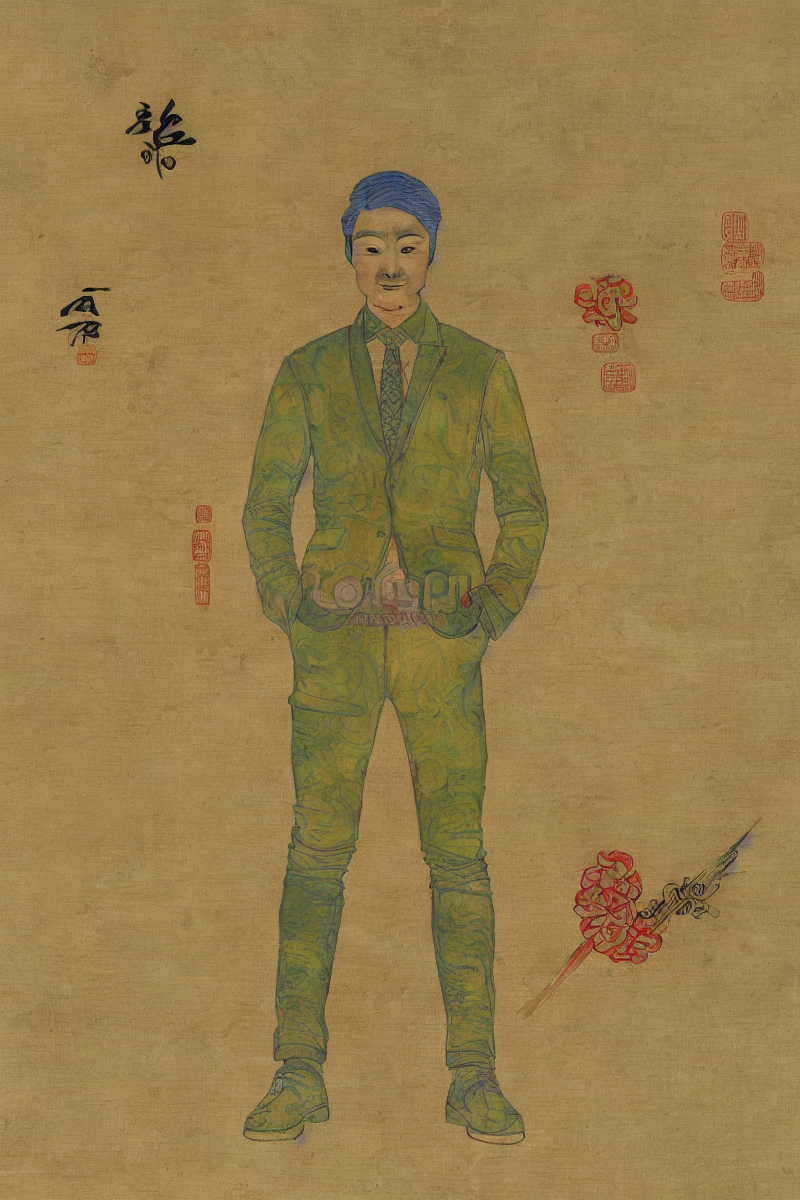

In [9]:
# 加载并预处理输入图像
input_image = cv2.imread("./human/human_6.jpg")
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, threshold1=100, threshold2=200)
edges_image = Image.fromarray(edges)

# 生成年画风格的图像
prompt = "a traditional Chinese New Year painting style of a warrior figure, vibrant colors, detailed lines"
generated_image = pipe(
    prompt, 
    image=edges_image, 
    num_inference_steps=120
    ).images[0]

# 保存生成结果
generated_image.save("./generated_images/test_6.jpg")
generated_image.show()